In [ ]:
!pip install --user qctrl

In [ ]:
!pip install --user qctrl-visualizer qctrl-open-controls

In [54]:
import matplotlib.pyplot as plt
import numpy as np

from qctrlvisualizer import get_qctrl_style, plot_controls
from qctrl import Qctrl

qctrl = Qctrl()

# The Challenge

In [55]:
control_count = 5
segment_count = 256
duration = 30.0
shot_count = 32

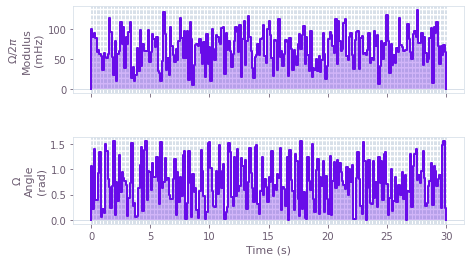

In [56]:
controls = []
for k in range(control_count):
    # Create a random string of complex numbers for each controls.
    real_part = np.random.random(size=[segment_count])
    imag_part = np.random.random(size=[segment_count])
    values = 0.15 * k * (real_part + 1j * imag_part)

    controls.append({"duration": duration, "values": values})

# Plot the last control as an example.
plot_controls(
    figure=plt.figure(),
    controls={
        "$\Omega$": [
            {"duration": duration / segment_count, "value": value} for value in values
        ]
    },
)

In [57]:
experiment_results = qctrl.functions.calculate_qchack_measurements(
    controls=controls,
    shot_count=shot_count,
)

  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_qchack_measurements has started.
Your task calculate_qchack_measurements has completed in 11s.


# CRAB


In [58]:
# Define standard matrices
a = np.array(
    [[0.0, 1.0], [0.0, 0.0]], dtype=np.complex
)
ada = np.matmul(a.T, a)
ad2a2 = np.matmul(np.matmul(a.T, a.T), np.matmul(a, a))
hadamard = np.array(
    [[1.0, 1.0], [1.0, -1.0]], dtype=np.complex
) / np.sqrt(2)
qubit_projector = np.array([[1, 0], [0, 0]], dtype=np.complex)

# Define physical constraints
chi = 2 * np.pi * -300.0 * 1e6  # Hz
gamma_max = 2 * np.pi * 30e6  # Hz
alpha_max = 2 * np.pi * 30e6  # Hz
segment_count = 200
duration = 100e-9  # s

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/opt/conda/lib/python

In [59]:
experiment_results = qctrl.functions.calculate_qchack_measurements(
    controls=controls,
    shot_count=shot_count,
)

  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_qchack_measurements has completed in 3s.


In [60]:
def get_optimized_matrix(target_operator,repetitions=1,shots=1024):
  # 5. SPAM error confusion matrix
  confusion_matrix = np.array([[0.99, 0.01], [0.02, 0.98]])

  with qctrl.create_graph() as graph:
    
      gamma_i = qctrl.operations.real_fourier_pwc_signal(
          duration=duration,
          segments_count=segment_count,
          randomized_frequencies_count=10,
      )
        
      gamma_q = qctrl.operations.real_fourier_pwc_signal(
          duration=duration,
          segments_count=segment_count,
          optimizable_frequencies_count=10,
      )
    
      gamma = qctrl.operations.pwc_signal(
          duration=duration,
          values=qctrl.operations.complex_value(real=gamma_i.values, imag=gamma_q.values) * gamma_max,
          name="gamma",
      )
        
      # Create alpha(t) signal
      alpha = qctrl.operations.real_fourier_pwc_signal(
          duration=duration,
          segments_count=segment_count,
          initial_coefficient_lower_bound=-alpha_max,
          initial_coefficient_upper_bound=alpha_max,
          optimizable_frequencies_count=10,
          name="alpha",
      )


      # Create anharmonicity term
      anharmonicity = qctrl.operations.constant_pwc_operator(
          duration,
          ad2a2 * chi / 2,
      )
    
      # Create drive term
      drive = qctrl.operations.pwc_operator_hermitian_part(
          qctrl.operations.pwc_operator(signal=gamma, operator=2 * a)
      )

      # Create clock shift term
      shift = qctrl.operations.pwc_operator(signal=alpha, operator=ada / 2)

      # Create target
      target_operator = qctrl.operations.target(operator=target_operator)

      #Construct Hamiltonian.
      hamiltonian = qctrl.operations.pwc_sum([anharmonicity, drive, shift])

      # Solve Schrodinger's equation and get total unitary at the end
      unitary = qctrl.operations.time_evolution_operators_pwc(
              hamiltonian=hamiltonian,
              sample_times=np.array([duration]),
          )[-1]
      unitary.name = "unitary"

      # Repeat final unitary
      repeated_unitary = np.eye(2)
      #print(unitary.shape)
      for _ in range(repetitions):
        repeated_unitary = repeated_unitary @ unitary
      repeated_unitary.name = "repeated_unitary"

      # Initial state
      initial_state = np.array([[1], [0]])

      # Calculate final state.
      state = repeated_unitary @ initial_state

      # Calculate final populations.
      populations = qctrl.operations.abs(state[:, 0]) ** 2
      # Normalize populations
      norm = qctrl.operations.sum(populations)
      populations = populations / norm
      populations.name = "populations"

      # Create infidelity
      infidelity = qctrl.operations.infidelity_pwc(
          hamiltonian=hamiltonian,
          target_operator=target_operator,
          noise_operators=[drive],
          name="infidelity",
      )

  # Run the optimization
  optimization_result = qctrl.functions.calculate_optimization(
      cost_node_name="infidelity",
      output_node_names=["alpha","gamma","unitary", "populations"],
      graph=graph,
  )


  print("Optimized cost:\t", optimization_result.cost)

  # Plot the optimized controls
  plot_controls(
      plt.figure(),
      controls={
          "$\\alpha$": optimization_result.output["alpha"],
          "$\\gamma$": optimization_result.output["gamma"],
      },
  )
  plt.show()


  #Extract Outputs
  unitary = optimization_result.output["unitary"]["value"]
  populations = optimization_result.output["populations"]["value"]

  # Sample projective measurements.
  true_measurements = np.random.choice(2, size=shots, p=populations)
  measurements = np.array(
      [np.random.choice(2, p=confusion_matrix[m]) for m in true_measurements]
  )

  results = {"unitary": unitary, "measurements": measurements}
  return results

  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization has started.
Your task calculate_optimization has completed in 23s.
Optimized cost:	 1.9243893118220267e-13


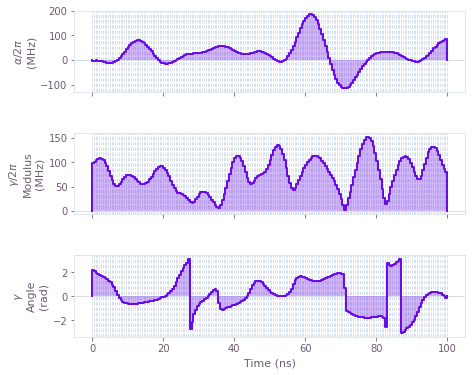

  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization has started.
Your task calculate_optimization has completed in 12s.
Optimized cost:	 8.504581767623579e-13


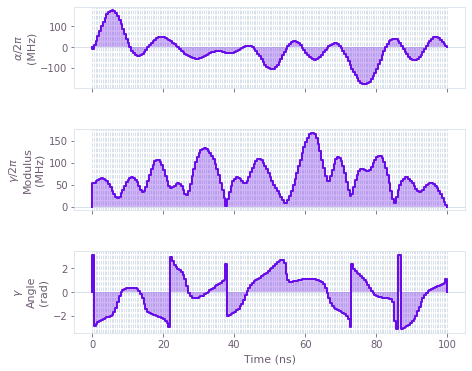

Realised NOT Gate:
[[1.15583783e-07-1.39782901e-08j 6.86293920e-01+7.27324312e-01j]
 [6.86293796e-01+7.27324429e-01j 2.06587892e-08-1.14578435e-07j]]
Ideal NOT Gate:
[[ 0.+0.j -0.-1.j]
 [-0.-1.j  0.+0.j]]
NOT Gate Error:4.440892098500626e-15
NOT estimated probability of getting 1:0.0146484375
NOT estimate standard error:0.00375440636676496

Realised H Gate:
[[-0.47340014+0.52525485j  0.5252545 +0.47339979j]
 [ 0.52525412+0.47340021j -0.47340053+0.5252545j ]]
Ideal H Gate:
[[0.70710678+0.j         0.        -0.70710678j]
 [0.        -0.70710678j 0.70710678+0.j        ]]
H Gate Error:2.5646151868841116e-13
H estimated probability of getting 1:0.0068359375
H estimate standard error:0.002574895222856183


In [61]:
error_norm = (
    lambda operate_a, operator_b: 1
    - np.abs(np.trace((operate_a.conj().T @ operator_b)) / 2) ** 2
)

def estimate_probability_of_one(measurements):
    size = len(measurements)
    probability = np.mean(measurements)
    standard_error = np.std(measurements) / np.sqrt(size)
    return (probability, standard_error)

not_op_matrix = get_optimized_matrix(ideal_not_gate,repetitions=100)
h_op_matrix = get_optimized_matrix(ideal_h_gate,repetitions=100)

realised_not_gate = not_op_matrix["unitary"]
ideal_not_gate = np.array([[0, -1j], [-1j, 0]])
not_error = error_norm(realised_not_gate, ideal_not_gate)
realised_h_gate = h_op_matrix["unitary"]
ideal_h_gate = (1 / np.sqrt(2)) * np.array([[1, -1j], [-1j, 1]])
h_error = error_norm(realised_h_gate, ideal_h_gate)

not_measurements = not_op_matrix["measurements"]
h_measurements = h_op_matrix["measurements"]
not_probability, not_standard_error = estimate_probability_of_one(not_measurements)
h_probability, h_standard_error = estimate_probability_of_one(h_measurements)

print("Realised NOT Gate:")
print(realised_not_gate)
print("Ideal NOT Gate:")
print(ideal_not_gate)
print("NOT Gate Error:" + str(not_error))
print("NOT estimated probability of getting 1:" + str(not_probability))
print("NOT estimate standard error:" + str(not_standard_error) + "\n")

print("Realised H Gate:")
print(realised_h_gate)
print("Ideal H Gate:")
print(ideal_h_gate)
print("H Gate Error:" + str(h_error))
print("H estimated probability of getting 1:" + str(h_probability))
print("H estimate standard error:" + str(h_standard_error))
